# **Topic Modeling on Amazon Reviews**

This notebook applies Latent Dirichlet Allocation (LDA) to Amazon reviews. The objective is to identify underlying topics from customer reviews, visualize the topics, and evaluate the model's performance using coherence and perplexity scores.

---

## **Step 1: Import Libraries**

We start by importing the necessary libraries for data handling (Pandas, NumPy), natural language processing (NLTK), topic modeling (Gensim), and visualizations (Matplotlib, pyLDAvis).

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

# NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Gensim libraries for topic modeling
import gensim
from gensim import corpora
from gensim.models import ldamodel, CoherenceModel

# Visualization libraries
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud

## Step 2: Load and Explore the Data
In this step, we load the Amazon review dataset and examine its structure to understand what kind of preprocessing is required before performing topic modeling.

In [2]:
# Load the dataset
df = pd.read_csv("K8 Reviews v0.2.csv")

# Display the first five rows of the dataset to get an overview
display(df.head())  # Using display() for a more readable output in Jupyter

# Check the shape of the dataset (rows, columns)
print(f"Dataset shape (rows, columns): {df.shape}")

,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...
3,1,Good
4,0,The worst phone everThey have changed the last...


Dataset shape (rows, columns): (14675, 2)


## Step 3: Text Preprocessing
We will preprocess the text by converting it to lowercase, tokenizing, removing stopwords, and lemmatizing the words in preparation for topic modeling.

### 1: Extract and display the first review for initial inspection

In [3]:
# Extract reviews and display the first one for inspection
reviews = df['review'].values.tolist()

print(f"First Review (before processing): {reviews[0]}\n")

First Review (before processing): Good but need updates and improvements



### 2: Convert reviews to lowercase

In [4]:
# Convert reviews to lowercase, print the first one for inspection
print(f"First Review (before converting to lowercase): {reviews[0]}")  # Display the first review before lowercase

reviews_lower = [review.lower() for review in reviews]  # Convert to lowercase

print(f"First Review (after converting to lowercase): {reviews_lower[0]}\n")  # Display the first review after lowercase

First Review (before converting to lowercase): Good but need updates and improvements
First Review (after converting to lowercase): good but need updates and improvements



### 3: Tokenization - Split reviews into tokens (words)

In [5]:
# Tokenize reviews, print the first one for inspection
print(f"First Review (before tokenization): {reviews_lower[0]}")  # Display the first review before tokenization

tokenized_reviews = [word_tokenize(review) for review in reviews_lower]  # Tokenize reviews

print(f"First Review (after tokenization): {tokenized_reviews[0]}\n")  # Display the first review after tokenization

First Review (before tokenization): good but need updates and improvements
First Review (after tokenization): ['good', 'but', 'need', 'updates', 'and', 'improvements']



### 4: Part of Speech (POS) tagging


In [6]:
# Apply POS tagging, print the first one for inspection
print(f"First Review (before POS tagging): {tokenized_reviews[0]}")  # Display the first review before POS tagging

tagged_reviews = [nltk.pos_tag(tokens) for tokens in tokenized_reviews]  # POS tagging

print(f"First Review (after POS tagging): {tagged_reviews[0]}\n")  # Display the first review after POS tagging

First Review (before POS tagging): ['good', 'but', 'need', 'updates', 'and', 'improvements']
First Review (after POS tagging): [('good', 'JJ'), ('but', 'CC'), ('need', 'VBP'), ('updates', 'NNS'), ('and', 'CC'), ('improvements', 'NNS')]



### 5: Extract only nouns

In [7]:
# Extract only nouns, print the first one for inspection
print(f"First Review (before extracting nouns): {tagged_reviews[0]}")  # Display the first review before extracting nouns

nouns_reviews = [[word for word, pos in sent if re.search("NN.*", pos)] for sent in tagged_reviews]  # Extract nouns

print(f"First Review (after extracting nouns): {nouns_reviews[0]}\n")  # Display the first review after extracting nouns

First Review (before extracting nouns): [('good', 'JJ'), ('but', 'CC'), ('need', 'VBP'), ('updates', 'NNS'), ('and', 'CC'), ('improvements', 'NNS')]
First Review (after extracting nouns): ['updates', 'improvements']



### 6: Lemmatization - Convert nouns to their base form

In [8]:
# Lemmatize nouns, print the first one for inspection
print(f"First Review (before lemmatization): {nouns_reviews[0]}")  # Display the first review before lemmatization

lemmatizer = WordNetLemmatizer()

lemmatized_reviews = [[lemmatizer.lemmatize(noun) for noun in sent] for sent in nouns_reviews]  # Lemmatize nouns

print(f"First Review (after lemmatization): {lemmatized_reviews[0]}\n")  # Display the first review after lemmatization

First Review (before lemmatization): ['updates', 'improvements']
First Review (after lemmatization): ['update', 'improvement']



### 7: Define stopwords and punctuation, then remove them

In [9]:
# Define stopwords and punctuation, remove them from reviews, print the first one for inspection
stop_words = stopwords.words('english') + list(punctuation)

print(f"First Review (before removing stopwords): {lemmatized_reviews[0]}")  # Display the first review before removing stopwords

processed_reviews = [[word for word in review if word not in stop_words] for review in lemmatized_reviews]  # Remove stopwords and punctuation

print(f"First Review (after removing stopwords): {processed_reviews[0]}\n")  # Display the first review after removing stopwords

First Review (before removing stopwords): ['update', 'improvement']
First Review (after removing stopwords): ['update', 'improvement']



## Step 4: Create Dictionary and Corpus
In this step, we create a dictionary mapping each word to an ID and generate a document-term matrix (corpus) to be used as input to the LDA model.

In [10]:
# Create dictionary mapping each word to a unique ID
id2word = corpora.Dictionary(processed_reviews)

# Create the Document-Term Matrix where each document is represented as a bag of words (BoW)
# 'doc2bow' converts each document into a list of tuples (word ID, frequency count)
corpus = [id2word.doc2bow(text) for text in processed_reviews]

## Step 5: Build and Evaluate the LDA Model
We build the LDA model to discover topics in the reviews. Additionally, we calculate the coherence score to evaluate the quality of the model.

In [11]:
# Build the LDA model with 4 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, random_state=100, chunksize=1000, passes=50, iterations=100)

# Print the topics generated by the LDA model
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

# Calculate the coherence score to evaluate the model
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_reviews, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}")


(0, '0.091*"phone" + 0.088*"battery" + 0.037*"mobile" + 0.036*"problem" + 0.032*"issue" + 0.024*"day" + 0.020*"time" + 0.018*"money" + 0.018*"...." + 0.017*"backup"')
(1, '0.037*"screen" + 0.034*"call" + 0.029*"feature" + 0.025*"option" + 0.015*"app" + 0.014*"mobile" + 0.012*"software" + 0.010*"cast" + 0.010*"apps" + 0.010*"smartphone"')
(2, '0.161*"phone" + 0.038*"price" + 0.036*"camera" + 0.032*"note" + 0.025*".." + 0.018*"feature" + 0.016*"k8" + 0.016*"lenovo" + 0.015*"range" + 0.013*"processor"')
(3, '0.092*"product" + 0.079*"camera" + 0.058*"quality" + 0.018*"device" + 0.015*"note" + 0.015*"speaker" + 0.015*"display" + 0.014*"sound" + 0.013*"issue" + 0.013*".."')
Coherence Score: 0.6039323165800115


## Step 6: Hyperparameter Tuning of LDA Model
In this step, we focus on optimizing the LDA model by tuning key hyperparameters like the number of topics, alpha (topic sparsity), and beta (word distribution). We build multiple models and evaluate them using the coherence score and perplexity.

### 1. Define the Tuning Function
The tune_lda_model function will iterate over combinations of the number of topics, alpha, and beta values, building an LDA model for each combination. The coherence score (indicating topic quality) and perplexity (indicating model generalization) are computed for each model.

In [12]:
def tune_lda_model(corpus, id2word, texts, start, limit, step, passes, alpha_values, beta_values):
    results = []
    models = []
    count = 1
    total_count = (limit - start) * (len(alpha_values)) * (len(beta_values))
    for num_topics in range(start, limit, step):
        for alpha in alpha_values:
            for beta in beta_values:

                # Print the start of the model building
                print('Building Model Number: ', count, '/', total_count)
                
                # Build the LDA model
                lda_model = gensim.models.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics=num_topics, 
                                                   random_state=100,
                                                   chunksize=1000,
                                                   passes=passes,
                                                   alpha=alpha,
                                                   eta=beta)

                # Save the model
                models.append(lda_model)
                
                # Calculate Coherence (C_v)
                coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
                coherence_lda = coherence_model_lda.get_coherence()
                
                # Calculate Perplexity
                perplexity = lda_model.log_perplexity(corpus)
                
                # Store results
                results.append((num_topics, alpha, beta, coherence_lda, perplexity))
                print(f"Num Topics: {num_topics}, Alpha: {alpha}, Beta: {beta}, Coherence: {coherence_lda:.4f}, Perplexity: {perplexity:.4f}")

                # Increment the count
                count += 1

                # Print the model building is completed
                print('Completed!')
                
    return results, models


### 2. Run Hyperparameter Tuning
We now define the range of topics, alpha, and beta values to tune. We then call the tune_lda_model function to generate and evaluate models across these parameters.

In [13]:
# Define the range for number of topics, alpha, and beta values
start = 2   # Minimum number of topics
limit = 15  # Maximum number of topics
step = 1    # Step size for number of topics
passes = 50  # Number of passes for LDA
alpha_values = ['symmetric', 'asymmetric']
beta_values = ['symmetric', 'auto']

# Run the tuning
results, models = tune_lda_model(corpus=corpus, id2word=id2word, texts=processed_reviews, 
                         start=start, limit=limit, step=step, passes=passes, 
                         alpha_values=alpha_values, beta_values=beta_values)


Building Model Number:  1 / 52
Num Topics: 2, Alpha: symmetric, Beta: symmetric, Coherence: 0.6273, Perplexity: -6.4766
Completed!
Building Model Number:  2 / 52
Num Topics: 2, Alpha: symmetric, Beta: auto, Coherence: 0.6273, Perplexity: -6.4381
Completed!
Building Model Number:  3 / 52
Num Topics: 2, Alpha: asymmetric, Beta: symmetric, Coherence: 0.5736, Perplexity: -6.4619
Completed!
Building Model Number:  4 / 52
Num Topics: 2, Alpha: asymmetric, Beta: auto, Coherence: 0.5736, Perplexity: -6.4323
Completed!
Building Model Number:  5 / 52
Num Topics: 3, Alpha: symmetric, Beta: symmetric, Coherence: 0.5953, Perplexity: -6.5096
Completed!
Building Model Number:  6 / 52
Num Topics: 3, Alpha: symmetric, Beta: auto, Coherence: 0.5953, Perplexity: -6.4879
Completed!
Building Model Number:  7 / 52
Num Topics: 3, Alpha: asymmetric, Beta: symmetric, Coherence: 0.5139, Perplexity: -6.4934
Completed!
Building Model Number:  8 / 52
Num Topics: 3, Alpha: asymmetric, Beta: auto, Coherence: 0.5139,

### 3. Visualize the Tuning Results
We now convert the tuning results into a DataFrame for easy manipulation and visualization. We'll plot the coherence and perplexity scores to identify the best combination of hyperparameters.

In [14]:
# Convert the results into a DataFrame
results_df = pd.DataFrame(results, columns=['Num Topics', 'Alpha', 'Beta', 'Coherence', 'Perplexity'])

# Display the first few rows of the dataframe to check
results_df.head()


,Num Topics,Alpha,Beta,Coherence,Perplexity
0,2,symmetric,symmetric,0.627332,-6.476618
1,2,symmetric,auto,0.627332,-6.438053
2,2,asymmetric,symmetric,0.573606,-6.461862
3,2,asymmetric,auto,0.573606,-6.432305
4,3,symmetric,symmetric,0.595319,-6.509594


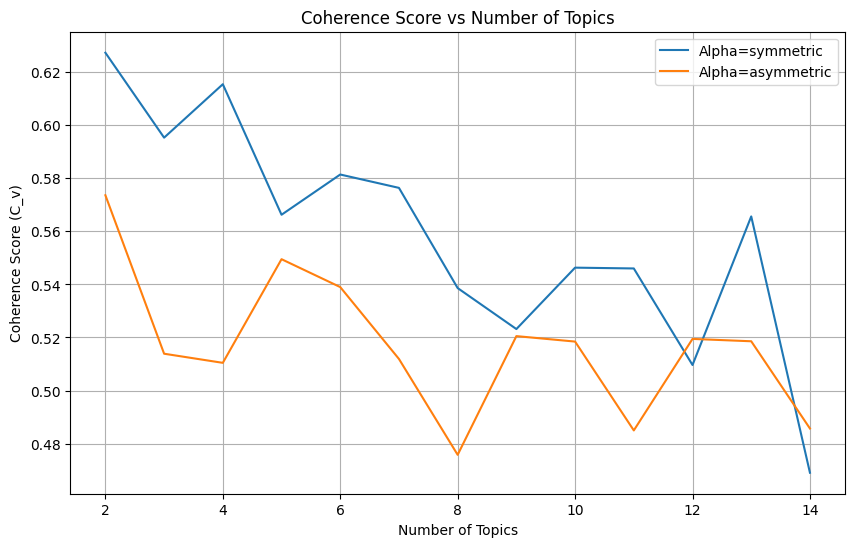

In [15]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot coherence score for each alpha value
for alpha in results_df['Alpha'].unique():
    subset = results_df[results_df['Alpha'] == alpha]
    plt.plot(subset['Num Topics'], subset['Coherence'], label=f'Alpha={alpha}')

# Add labels and title
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (C_v)")
plt.title("Coherence Score vs Number of Topics")

# Display legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


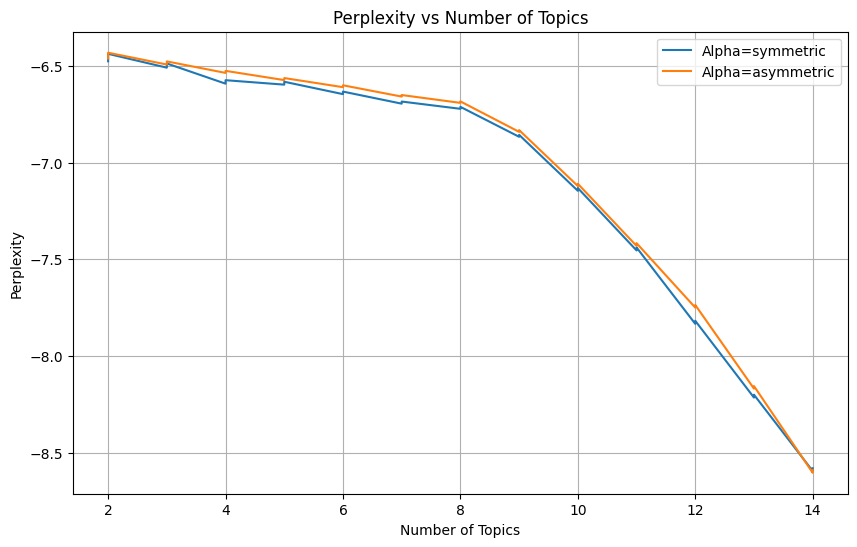

In [16]:
# Create the plot
plt.figure(figsize=(10, 6))

# Loop through each unique alpha value and plot perplexity
for alpha in results_df['Alpha'].unique():
    subset = results_df[results_df['Alpha'] == alpha]
    plt.plot(subset['Num Topics'], subset['Perplexity'], label=f'Alpha={alpha}')

# Set labels and title
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity vs Number of Topics")

# Display legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## Step 7: Visualize the Topics
We will use pyLDAvis to visualize the topics discovered by the LDA model. This visualization helps explore the relationships between topics and words.

In [20]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Enable pyLDAvis in notebook
pyLDAvis.enable_notebook()

# Define a function to retrieve the LDA model for a specific number of topics, alpha, and beta
def get_model_by_params(num_topics, alpha, beta, results, models):
    """
    Retrieve the LDA model that matches the specified number of topics, alpha, and beta values.

    Parameters:
    ----------
    num_topics : int
        The number of topics the model should have.
    alpha : str
        The alpha value used in the model ('symmetric' or 'asymmetric').
    beta : str
        The beta (eta) value used in the model ('symmetric' or 'auto').
    results : list of tuples
        A list containing the tuning results. Each tuple contains:
        (num_topics, alpha, beta, coherence, perplexity).
    models : list
        A list of LDA models that were tuned during the hyperparameter search.

    Returns:
    -------
    model : gensim.models.LdaModel or None
        The LDA model that matches the specified number of topics, alpha, and beta,
        or None if no matching model is found.
    """
    for i, (topics, a, b, coherence, perplexity) in enumerate(results):  # Adjusted to 5 elements
        if topics == num_topics and a == alpha and b == beta:
            return models[i]
    return None

# Retrieve and save LDAvis for models with 2, 3, and 4 topics, with symmetric alpha and symmetric beta
model_2_symmetric_alpha_beta = get_model_by_params(2, 'symmetric', 'symmetric', results, models)
model_3_symmetric_alpha_beta = get_model_by_params(3, 'symmetric', 'symmetric', results, models)
model_4_symmetric_alpha_beta = get_model_by_params(4, 'symmetric', 'symmetric', results, models)


In [21]:

# Visualize the model with 2 topics
print("Visualizing topics for model with 2 topics:")
LDAvis_prepared_2 = gensimvis.prepare(model_2_symmetric_alpha_beta, corpus, id2word)
LDAvis_prepared_2

Visualizing topics for model with 2 topics:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.220674  0.0       1        1  64.072768
1     -0.220674  0.0       2        1  35.927232, topic_info=           Term         Freq        Total Category  logprob  loglift
17        phone  6405.000000  6405.000000  Default  30.0000  30.0000
51      product  2053.000000  2053.000000  Default  29.0000  29.0000
12       mobile  1386.000000  1386.000000  Default  28.0000  28.0000
59       camera  2971.000000  2971.000000  Default  27.0000  27.0000
4       battery  2812.000000  2812.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
255      please   123.529910   173.086073   Topic2  -5.5592   0.6864
102     feature   187.279032   774.312125   Topic2  -5.1431  -0.3957
94          day   183.909347   831.333448   Topic2  -5.1613  -0.4849
18      problem   191.247867  1405.819188   Topic2  -5.1221  -0.9711
249  experience   132.755043   263.712176   Topic2  -5.4872   0.3373

[117 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
14        1  0.998021      ..
14        2  0.001459      ..
144       1  0.997123    ....
144       2  0.001759    ....
2         1  0.001927  amazon
...     ...       ...     ...
116       2  0.004579   value
201       1  0.010575   voice
201       2  0.994092   voice
190       1  0.994114   waste
190       2  0.003868   waste

[161 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [22]:

# Visualize the model with 3 topics
print("Visualizing topics for model with 3 topics:")
LDAvis_prepared_3 = gensimvis.prepare(model_3_symmetric_alpha_beta, corpus, id2word)
LDAvis_prepared_3

Visualizing topics for model with 3 topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.120655  0.230117       1        1  42.186887
0     -0.177630 -0.202568       2        1  42.023946
1      0.298285 -0.027548       3        1  15.789167, topic_info=            Term         Freq        Total Category  logprob  loglift
51       product  2044.000000  2044.000000  Default  30.0000  30.0000
59        camera  2983.000000  2983.000000  Default  29.0000  29.0000
4        battery  2817.000000  2817.000000  Default  28.0000  28.0000
17         phone  6425.000000  6425.000000  Default  27.0000  27.0000
18       problem  1407.000000  1407.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
633  application    49.008781   103.757098   Topic3  -5.6615   1.0958
62          call    62.597428   448.661533   Topic3  -5.4168  -0.1237
104        .....    51.508035   236.479961   Topic3  -5.6118   0.3217
151     delivery    44.523589   218.968427   Topic3  -5.7575   0.2529
68       display    44.865040   327.194992   Topic3  -5.7499  -0.1411

[153 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
14        1  0.581093        ..
14        2  0.418911        ..
144       2  0.998716      ....
104       1  0.342524     .....
104       2  0.439784     .....
...     ...       ...       ...
607       1  0.994376     video
190       2  0.996063     waste
595       3  0.993461  whatsapp
632       3  0.996385     worth
350       3  0.986052        ye

[143 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [23]:

# Visualize the model with 4 topics
print("Visualizing topics for model with 4 topics:")
LDAvis_prepared_4 = gensimvis.prepare(model_4_symmetric_alpha_beta, corpus, id2word)
LDAvis_prepared_4

Visualizing topics for model with 4 topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.156857 -0.090036       1        1  33.686177
2     -0.122213 -0.130482       2        1  26.822535
3     -0.039616  0.280058       3        1  24.151250
1      0.318686 -0.059540       4        1  15.340039, topic_info=        Term         Freq        Total Category  logprob  loglift
17     phone  6377.000000  6377.000000  Default  30.0000  30.0000
4    battery  2814.000000  2814.000000  Default  29.0000  29.0000
51   product  2051.000000  2051.000000  Default  28.0000  28.0000
59    camera  2956.000000  2956.000000  Default  27.0000  27.0000
28      note  1039.000000  1039.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
12    mobile   198.630750  1381.954645   Topic4  -4.2332  -0.0651
1     update   108.808031   349.019344   Topic4  -4.8351   0.7092
669    power    77.027431   134.781791   Topic4  -5.1805   1.3152
511    light    73.135660   136.147854   Topic4  -5.2324   1.2533
136     mode    79.150091   325.142459   Topic4  -5.1533   0.4618

[211 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
14        1  0.363649        ..
14        2  0.495352        ..
14        3  0.140484        ..
144       1  0.997933      ....
2         1  0.662163    amazon
...     ...       ...       ...
455       1  0.989043  warranty
190       1  0.997027     waste
219       3  0.995124      work
632       4  0.997111     worth
30        1  0.988307      year

[212 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

### Selecting 3-Topic Model

The **3-topic model** provides a good balance due to:

- **Distinct topics**: Minimal overlap between topics, capturing unique sets of words.
- **Interpretability**: Each topic is focused:
  - **Topic 1**: Issues and performance.
  - **Topic 2**: Sales and after-sales.
  - **Topic 3**: Features and specifications.
  
- **Better distribution**: Topics are evenly spread across the documents.

Compared to the **2-topic model** (too broad) and the **4-topic model** (redundant topics), the 3-topic model is more effective for capturing clear and meaningful topics.


## Step 8: Remove Unwanted Tokens and Rebuild the LDA Model
In this step, we focus on cleaning the tokenized text data by removing unwanted tokens such as '..', '...', '....', '.....', '......'. After updating the stopword list, we will reprocess the text data, rebuild the LDA model, and evaluate the updated topics to ensure the unwanted tokens are successfully removed.

In [24]:
# Add unwanted tokens to the stopwords list
custom_stopwords = ['..', '...', '....', '.....', '......']  # Add specific stopwords
updated_stop_words = stopwords.words('english') + list(punctuation) + custom_stopwords

def remove_custom_stopwords(texts, stop_words):
    """
    Removes stopwords from the tokenized text data.

    Args:
        texts (list of list of str): A list of tokenized text documents, 
                                     where each document is represented as a list of words.
        stop_words (list of str): A list of stopwords to be removed from the text data.

    Returns:
        cleaned_texts (list of list of str): A list of tokenized text documents with stopwords removed.
    """
    
    # Initialize an empty list to store cleaned texts
    cleaned_texts = []
    
    # Iterate over each document (tokenized text) in the provided list
    for text in texts:
        
        # Filter out words that are in the stopwords list
        cleaned_text = [word for word in text if word not in stop_words]
        
        # Append the cleaned text (with stopwords removed) to the cleaned_texts list
        cleaned_texts.append(cleaned_text)
    
    # Return the cleaned texts
    return cleaned_texts


# Reprocess the reviews to remove the new stopwords
cleaned_reviews = remove_custom_stopwords(processed_reviews, updated_stop_words)

# Create the dictionary and corpus again
id2word = corpora.Dictionary(cleaned_reviews)
corpus = [id2word.doc2bow(text) for text in cleaned_reviews]

# Rebuild the LDA model (let's use the model with 3 topics as an example)
num_topics = 3  # You can adjust the number of topics as needed
lda_model_cleaned = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=1000,
                                           passes=50)

# Print the topics to check if the unwanted tokens were removed
print("Updated Topics after removing custom stopwords:")
for idx, topic in lda_model_cleaned.print_topics(-1, num_words=10):
    print(f"Topic {idx+1}:")
    print(", ".join([word for word, _ in lda_model_cleaned.show_topic(idx, topn=10)]))
    print("\n")


Updated Topics after removing custom stopwords:
Topic 1:
product, mobile, money, amazon, network, note, service, problem, lenovo, issue


Topic 2:
phone, battery, camera, problem, issue, performance, price, day, time, backup


Topic 3:
camera, quality, note, feature, speaker, sound, call, video, option, screen




## Step 7: Word Cloud Visualization of Topics
We generate word clouds for each topic to visualize the most relevant words associated with each one.

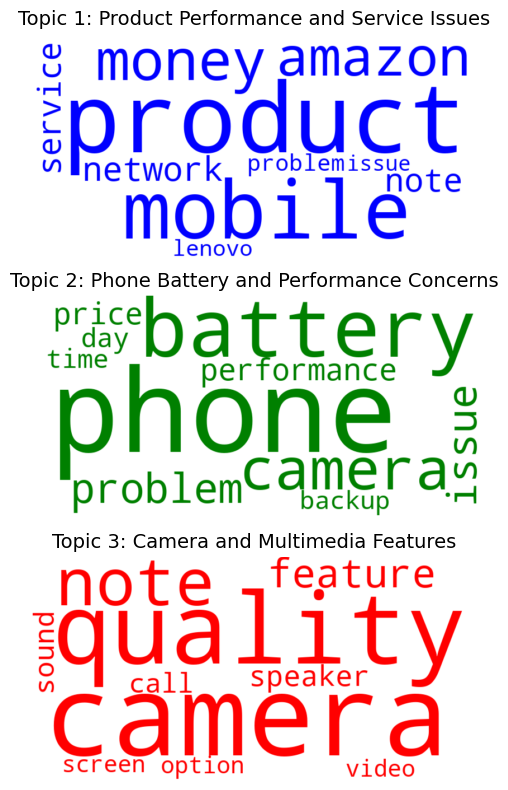

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define a function to create a word cloud for a given topic
def create_wordcloud(topic_words, ax, title, color):
    """
    Create a word cloud for a given topic and plot it on the specified axis.

    Parameters:
    -----------
    topic_words : dict
        A dictionary of words and their corresponding weights for the topic.
    ax : matplotlib.axes.Axes
        The axis on which to plot the word cloud.
    title : str
        The title of the word cloud (typically the topic name).
    color : str
        The color to use for the word cloud.
    """
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab10', 
                          color_func=lambda *args, **kwargs: color).generate_from_frequencies(topic_words)
    
    # Plot the word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=14)
    ax.axis('off')  # Hide the axis

# Example usage of the function:
# Get the topics from the LDA model with 3 topics
topics = lda_model_cleaned.show_topics(formatted=False, num_topics=3)

# Assign names to topics
topic_names = ['Product Performance and Service Issues', 'Phone Battery and Performance Concerns', 'Camera and Multimedia Features']

# Define a color list for the word clouds
cols = ['blue', 'green', 'red']

# Visualize word clouds for each topic
fig, axes = plt.subplots(3, 1, figsize=(15, 8), sharex=True, sharey=True)

# Generate word clouds for each topic
for i, ax in enumerate(axes.flatten()):
    topic_words = dict(topics[i][1])  # Get the words and their frequencies for each topic
    create_wordcloud(topic_words, ax, f"Topic {i+1}: {topic_names[i]}", cols[i])

# Adjust subplot layout and remove additional spaces
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.axis('off')
plt.margins(x=0, y=0)  # Ensure no margins around the figure
plt.tight_layout()
plt.show()
